# 머신러닝 프로젝트 처음부터 끝까지

**데이터 과학자가 프로젝트에서 하는 일의 단계**

1. 큰 그림 보기
2. 데이터 준비
3. 데이터로부터 통찰을 얻기 위해 탐색하고 시각화
4. 머신러닝 알고리즘을 위한 데이터 준비
5. 모델 선택, 훈련
6. 모델 조정
7. 솔루션 제시
8. 론칭, 모니터링, 유지보수

##2.1. 실제 데이터로 작업하기

StatLib 저장소[1] 의 캘리포니아 주택 가격 데이터셋을 사용 (1990년 캘리포니아 인구조사 데이터 기반)


[1] 카네기 멜로 대학교 통계학과에서 운영하는 공개 데이터셋 저장소

## 2.2. 큰 그림 보기
미션: 캘리포니아 인구조사 데이터를 사용해 캘리포니아 주택 가격 모델 만들기

- 입력: 인구조사 데이터 (구역별 위도/경도, 인구수, 평균 소득, 방 갯수, 등등)
- 출력: 구역별 추정 주택 가격

### 2.2.1. 문제 정의

|상위 컴포넌트| ----구역 데이터----> **|구역 가격 결정(나의 컴포넌트)|** ----구역 가격----> |투자 분석 컴포넌트| ------>투자

이 문제는
- 레이블된 데이터를 사용하므로 지도 학습 작업이 적절
- 구역 가격을 예측하므로 회귀 문제에 속함
- 데이터양이 많지 않으므로 배치학습이 적절

### 2.2.2. 성능 측정 지표 선택
- RMSE (Root Mean Square Error, 평균 제곱근 오차)

## 2.3. 데이터 가져오기
###2.3.1. 작업환경 만들기
Jupyter Notebook 을 설치하는 방법이 있지만 시간관계상 오늘은 [Google Colab](
https://colab.research.google.com/github/sjp38/handson_ml/blob/master/ch2_end_to_end/housing.ipynb) 를 사용합니다.

* Jupyter Notebook 과 Google Colab 에 대한 간단한 소개:
https://sjp38.github.io/post/ml-study-env/

### 2.3.2. 데이터 다운로드
```
$ wget https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.tgz
$ tar zxvf housing.tgz
$ cat housing.csv
```

In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
  if not os.path.isdir(housing_path):
    os.makedirs(housing_path)
  tgz_path = os.path.join(housing_path, "housing.tgz")
  urllib.request.urlretrieve(housing_url, tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()

In [2]:
fetch_housing_data()

csv 를 읽어들여 pandas [DataFrame object](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) 로 변환

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
  csv_path = os.path.join(housing_path, "housing.csv")
  return pd.read_csv(csv_path)

### 2.3.3. 데이터 구조 훑어보기

In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


숫자형이 아닌 필드에 대해 카테고리 종류와 카테고리별 갯수를 확인

In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

숫자형 특성 정보를 요약

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


숫자형 특성정보를 히스토그램으로 파악

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4bb39c86a0>,
      dtype=object)

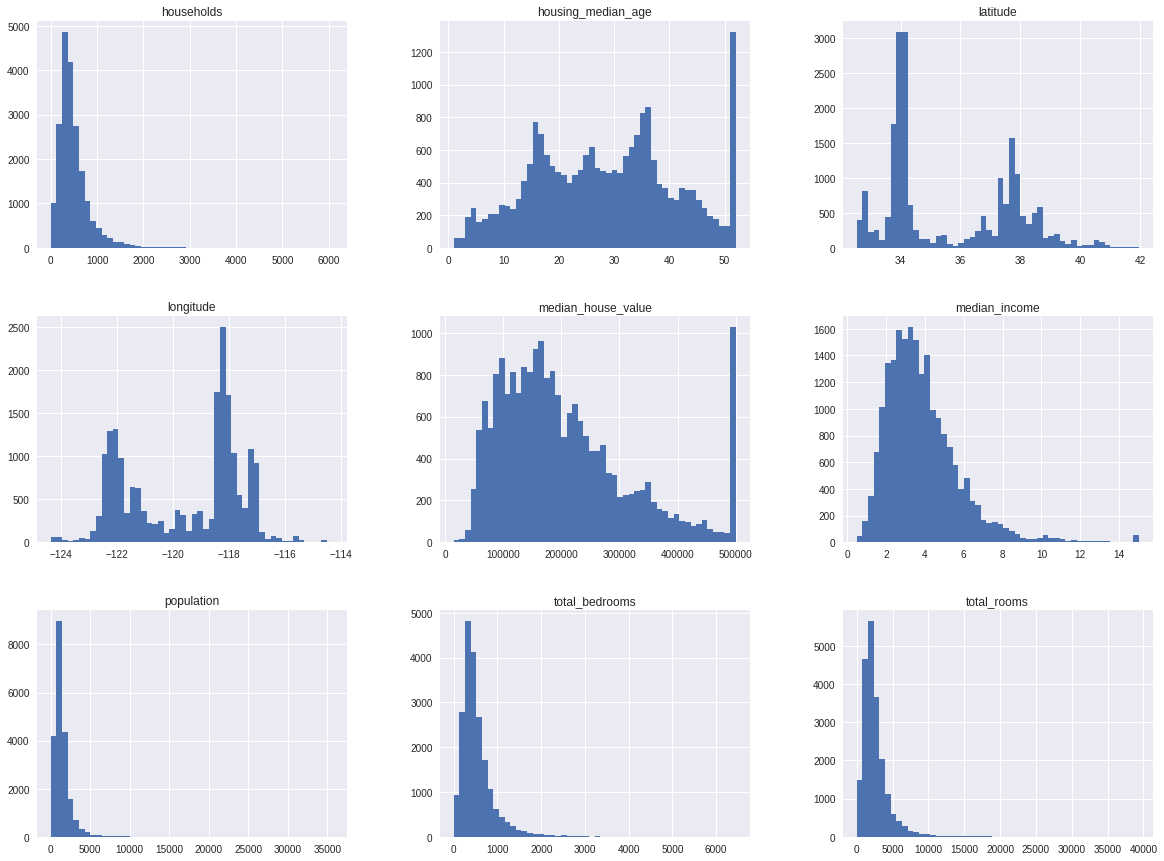

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))

### 2.3.4. 테스트 세트 만들기

단순히 무작위로 데이터셋의 20% 를 테스트셋으로 만들기.

In [9]:
import numpy as np

def split_train_test(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  # pandas.DataFrame.iloc(): integer-location based indexing for selection by position.
  return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train_set, test_set = split_train_test(housing, 0.2)
print (len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


매번 테스트 셋과 트레인 셋이 섞일 수 있음.  난수 seed() 를 고정할 수 있겠지만 데이터셋이 업데이트 되면 또다시 섞일 수 있음.
식별자의 해시값을 이용하는게 좋은 방법.

In [11]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
  return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
  # pandas.DataFrame.loc(): Access a group of rows and columns by label(s) or a boolean array
  return data.loc[~in_test_set], data.loc[in_test_set]

인덱스를 식별자로 사용해 20% 데이터를 test set 으로 활용.

In [12]:
# reset_index() returns index column added dataframe
housing_with_id = housing.reset_index()
#housing_with_id.head()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

인덱스를 식별자로 사용하는 경우, 차후 데이터가 같은 인덱스에 다른 데이터를 갖는다면 문제가 될 소지 있음.  longitude 와 latitude 를 조합해 식별자로 활용하는 것도 좋은 방법.

In [13]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
# housing_with_id.head()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

sklearn 에서 제공하는 train_test_split() 을 활용하는 것도 가능.  이 경우 random seed 42 를 준것과 비슷.

In [14]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

무작위 샘플링의 단점: 샘플링 편향.

계층적 샘플링 (stratified sampling) 을 통해 이를 극복 가능.  전문가가 중간 주택 가격 예측에 중간 소득이 매우 중요하다고 이야기 해줬다는 가정 하에 test set 이 전체 data set 의 소득 카테고리를 잘 대표하도록, 그러나 카테고리가 너무 세분화 되지 않아 카테고리별 샘플이 충분하도록 다섯개 카테고리로 다음과 같이 분류.

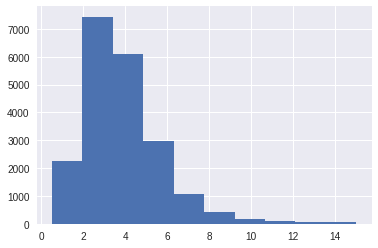

In [15]:
housing["median_income"].hist()

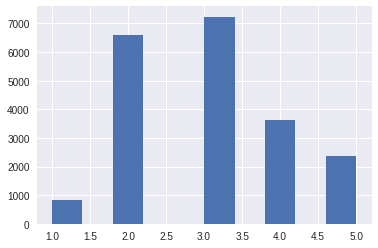

In [16]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
housing["income_cat"].hist()

sklearn 의 StratifiedShuffleSplit() 을 사용해 income_cat 카테고리 기반으로 train set 과 test set 을 분리

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

data set 과 test set 의 소득 카테고리가 비슷하게 분포되어 있음을 알 수 있다 (샘플링 편향이 거의 없다).

In [18]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [19]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

train set 과 test set 에서 income_cat column 을 제거.

In [20]:
for set_ in (strat_train_set ,strat_test_set):
  set_.drop("income_cat", axis=1, inplace=True)

## 2.4. 데이터 이해를 위한 탐색과 시각화

데이터 손상을 피하기 위해 train set 의 복사본을 만든다.

In [21]:
housing = strat_train_set.copy()

### 2.4.1. 지리적 데이터 시각화

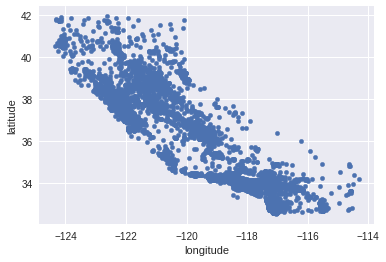

In [22]:
housing.plot(kind="scatter", x="longitude", y="latitude")

샘플의 밀집 지역을 알아보자.

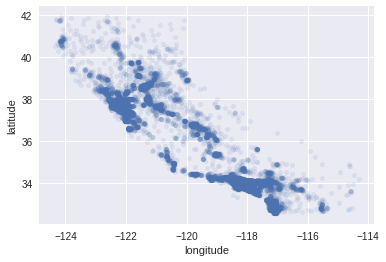

In [23]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

주택 가격까지 시각화.  원의 반지름이 구역의 인구, 색깔은 가격을 의미.

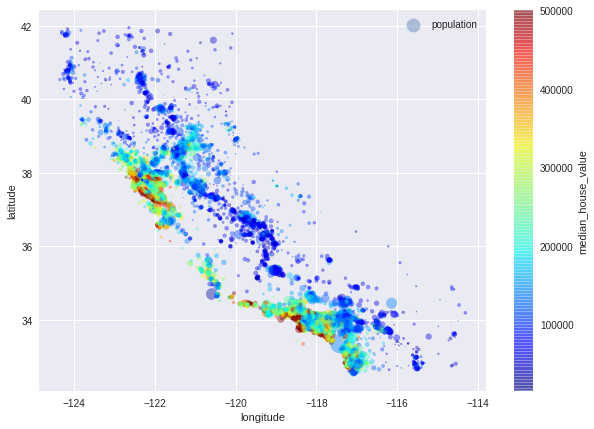

In [24]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            s=housing["population"]/100, label="population", figsize=(10,7),
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()

### 2.4.2. 상관관계 조사

In [25]:
corr_matrix = housing.corr()

"median_house_value" 와 다른 필드들 사이의 상관관계 크기를 확인

In [26]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4bafd849b0>,
      dtype=object)

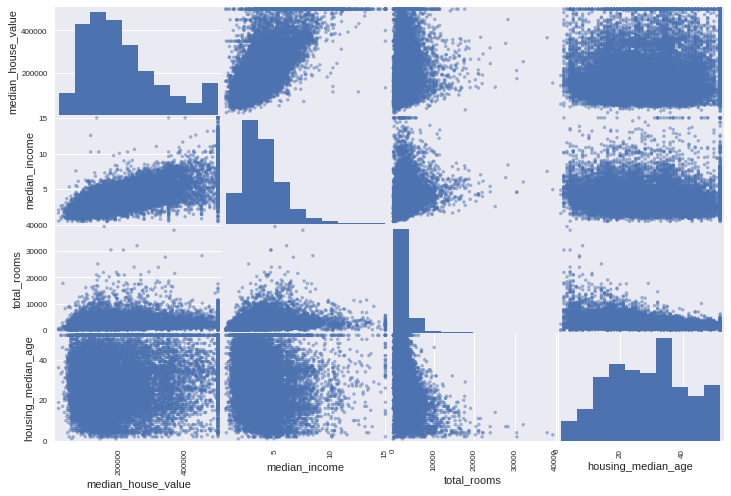

In [27]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
             "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))

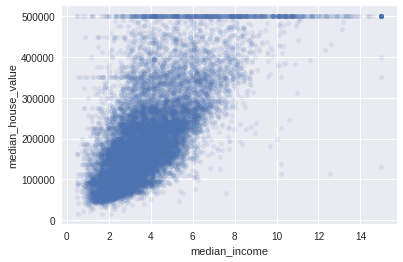

In [28]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

### 2.4.3. 특성 조합으로 실험

주어진 데이터에서 더 유의미할 것들을 조합해서 활용할 수 있다.

In [29]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [30]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## 2.5. 머신러닝 알고리즘을 위한 데이터 준비

라벨(정답)을 떼어낸 train data 를 준비하고 라벨만 따로 떼어낸 별도의 데이터를 생성.

In [31]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### 2.5.1. 데이터 정제


total_bedrooms 에 값이 없는 샘플들을 고쳐야함.
- option 1: 해당 값이 없는 row 를 제거
- option 2: 해당 column 을 제거
- option 3: 평균값으로 설정

In [32]:
#housing.dropna(subset=["total_bedrooms"]) # option 1
#housing.drop("total_bedrooms", axis=1) # option 2
#median = housing["total_bedrooms"].median() # option 3
#housing["total_bedrooms"].fillna(median, inplace=True)

sklearn 의 Imputer 를 사용해 쉽게 누락된 값 처리 가능.  여기선 세번째 옵션.

In [33]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

In [34]:
# Drop non-number column first
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [35]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [36]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [37]:
# Use imputer to get numpy array
X = imputer.transform(housing_num)

In [38]:
# Transform the numpy array into Pandas DataFrame again
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index = list(housing.index.values))

### 2.5.2. 텍스트와 범주형 특성 다루기

In [39]:
housing_cat = housing["ocean_proximity"]
housing_cat.head(10)

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

pandas 의 factorize() 를 사용해 각 카테고리를 정수값으로 매핑

In [40]:
housing_cat_encoded, housing_categories = housing_cat.factorize()
housing_cat_encoded[:10]

array([0, 0, 1, 2, 0, 2, 0, 2, 0, 0])

In [41]:
housing_categories

Index(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'], dtype='object')

factorize 는 카테고리 간의 유사도를 머신러닝 알고리즘이 오해할 수 있게 함. one-hot encoding 을 이용해 이를 해결.

In [42]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [43]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

sklearn 0.20.0 버전부터는 더 나은 encoder 들이 지원됩니다만, colab 의 sklearn 은 0.19 버전입니다. ageron/handson-ml github 에서 future_encoders.py 를 가져와 이 runtime 에 업로드 하고 여기서 제공하는 것들을 사용해 앞서 해본 것들을 해봅시다.

In [44]:
from google.colab import files

uploaded = files.upload()

Saving future_encoders.py to future_encoders (1).py


In [45]:
from future_encoders import OrdinalEncoder

In [46]:
housing_cat = housing[['ocean_proximity']]
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [47]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [48]:
from future_encoders import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [49]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [50]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [51]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### 2.5.3. 나만의 변환기

가구별 방 갯수, 가구별 가족수를 추가하고 방별 침실 갯수를 선택적으로 추가하는 변환기를 생성.

In [52]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
  def __init__(self, add_bedrooms_per_room = True):
    self.add_bedrooms_per_room = add_bedrooms_per_room
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if self.add_bedrooms_per_room:
      bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
      return np.c_[X, rooms_per_household, population_per_household,
                   bedrooms_per_room]
    else:
      return np.c_[X, rooms_per_household, population_per_household]
    
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room = False)
housing_extra_attribs = attr_adder.transform(housing.values)

### 2.5.4. 특성 스케일링

sklearn 의 StandardScaler 변환기는 표준화를 제공 (평균을 뺀 후 표준편차로 나눔)

### 2.5.5. 변환 파이프라인

숫자 특성 처리 파이프라인: 누락값을 채우고 추가 칼럼을 집어넣고 표준화를 수행.

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

DataFrame 을 Pipeline 에 주입하기 위한 변환기를 작성.

In [54]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
  def __init__(self, attribute_names):
    self.attribute_names = attribute_names
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    return X[self.attribute_names].values

In [55]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', OneHotEncoder(sparse=False)),
])

In [56]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

In [57]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [58]:
housing_prepared.shape

(16512, 16)

## 2.6. 모델 선택과 훈련

### 2.6.1. 훈련 세트에서 훈련하고 평가하기

linear regression 모델을 사용해 훈련

In [59]:
from sklearn.linear_model import LinearRegression

housing_labels = strat_train_set["median_house_value"].copy()

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

training set 로 테스트

In [60]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("예측: ", lin_reg.predict(some_data_prepared))
print("레이블: ", list(some_labels))

예측:  [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
레이블:  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


전체 training set 에 대한 이 회귀모델의 RMSE를 측정

In [61]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

DecisionTreeRegessor 로 훈련

In [62]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [63]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

### 2.6.2. 교차 검증을 사용한 평가

In [64]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [65]:
def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())
  
display_scores(tree_rmse_scores)

Scores: [70312.84614556 66677.19404062 70262.58070812 68949.26693374
 71778.00266648 74639.36081806 71375.89434761 71151.14543415
 76176.10355484 70161.33124782]
Mean: 71148.37258970013
Standard deviation: 2553.385418451372


In [66]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                            scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798344


In [67]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [68]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

22120.66491836238

In [69]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                               scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [52420.8962342  50996.40261069 52640.69323221 53110.35357591
 51668.67385727 55600.42759545 51664.30577657 50082.42791063
 55329.66552401 51590.53722865]
Mean: 52510.43835455975
Standard deviation: 1683.425750620147


## 2.7. 모델 세부 튜닝

### 2.7.1. 그리드 탐색

In [70]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2,4,6,8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2,3,4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [71]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [72]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [73]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(np.sqrt(-mean_score), params)

63786.58116996013 {'max_features': 2, 'n_estimators': 3}
55585.5714245506 {'max_features': 2, 'n_estimators': 10}
53026.5796632897 {'max_features': 2, 'n_estimators': 30}
59499.51661166599 {'max_features': 4, 'n_estimators': 3}
53099.82679803339 {'max_features': 4, 'n_estimators': 10}
50846.47196643017 {'max_features': 4, 'n_estimators': 30}
59068.402050570745 {'max_features': 6, 'n_estimators': 3}
52110.34944877745 {'max_features': 6, 'n_estimators': 10}
50195.34316591242 {'max_features': 6, 'n_estimators': 30}
58756.21348064182 {'max_features': 8, 'n_estimators': 3}
51832.66648992508 {'max_features': 8, 'n_estimators': 10}
49977.25963726337 {'max_features': 8, 'n_estimators': 30}
63002.1239713041 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54689.61821798512 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59407.82799589186 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52819.462774750624 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}

### 2.7.4. 최상의 모델과 오차 분석

In [74]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.69769965e-02, 6.42401140e-02, 4.42184007e-02, 1.51809954e-02,
       1.40023693e-02, 1.53360636e-02, 1.38918858e-02, 3.63325407e-01,
       5.78916605e-02, 1.14985782e-01, 5.83027314e-02, 5.18676191e-03,
       1.60703383e-01, 1.51648139e-04, 2.24545251e-03, 3.36034844e-03])

In [75]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36332540653116935, 'median_income'),
 (0.11498578189149734, 'pop_per_hhold'),
 (0.06697699652720632, 'longitude'),
 (0.064240113990902, 'latitude'),
 (0.05830273140536804, 'bedrooms_per_room'),
 (0.05789166050038959, 'rooms_per_hhold'),
 (0.0442184007022926, 'housing_median_age'),
 (0.01533606363048221, 'population'),
 (0.015180995350773819, 'total_rooms'),
 (0.014002369335710056, 'total_bedrooms'),
 (0.013891885810383867, 'households'),
 (0.005186761909180391, 'a')]

### 2.7.5. 테스트 세트로 시스템 평가하기

In [76]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [77]:
final_rmse

47732.02877686603

## 2.8. 론칭, 모니터링, 그리고 시스템 유지 보수

- 입력 데이터 소스를 우리 컴포넌트에 연결하고 테스트 코드를 작성
- 일정 간격으로 시스템 성능 체크, 모니터링 코드 작성
- 입력 데이터 품질 평가
- 새로운 데이터로 정기적으로 모델을 훈련


## 2.9. 직접 해보세요!


## 2.10. 연습문제

https://github.com/rickiepark/handson-ml